In [1]:
# write your code here
#Linear Classification
import math
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

#load dataset
def get_test_data():
    data = load_svmlight_file("a9a.test")
    return data[0], data[1]
def get_val_data():
    data = load_svmlight_file("a9a.validation")
    return data[0], data[1]

X_train, y_train = get_test_data()
X_train = X_train.toarray()
X_validation, y_validation = get_val_data()
X_validation = X_validation.toarray()
print(X_train.shape)
print(X_validation.shape)
#X_train = [X_train, 1]
addone_train = np.ones( X_train.shape[0])
X_train = np.column_stack((X_train,addone_train))
print(X_train.shape)

#X_validation = [X_validation,0,1]
addzero = np.zeros(( X_validation.shape[0]))
X_validation = np.column_stack((X_validation,addzero))
addone = np.ones( X_validation.shape[0])
X_validation = np.column_stack((X_validation,addone))
print(X_validation.shape)

(32561, 123)
(16281, 122)
(32561, 124)
(16281, 124)


In [3]:
# Initialize with normal distribution
N = X_train.shape[1]
W_normal = np.random.normal(size=N)

In [8]:
#Hinge loss function
def cal_Loss(X,W,y,lambdal,W_0):
    preY = np.dot(X,W)
    difY = np.ones(y.shape[0]) - y * preY
    difY[difY < 0] =0
    Loss =np.sum(difY) / X.shape[0] + np.dot(W_0,W_0.T)/2*lambdal
    return Loss
#calculate the gradient
def cal_G(X,W,y,lambdal,W_0):
    preY = np.dot(X,W)
    difY = np.ones(y.shape[0]) - y * preY
    y_get = y.copy()
    y_get[difY <= 0] =0
    G = -np.dot(y_get,X) / X.shape[0] + W_0 *lambdal
    return G

def shuffle_array(X_train):
    randomlist = np.arange(X_train.shape[0])
    np.random.shuffle(randomlist)
    X_random = X_train[randomlist]
    y_random = y_train[randomlist]
    return X_random,y_random

def get_Batch(runs,X_random,y_random,batch_size,shape):
    if l == runs-1:
        X_batch = X_random[l*batch_size:shape+1]
        y_batch = y_random[l*batch_size:shape+1]
    else:
        X_batch = X_random[l*batch_size:(l+1)*batch_size]
        y_batch = y_random[l*batch_size:(l+1)*batch_size]
    return X_batch,y_batch

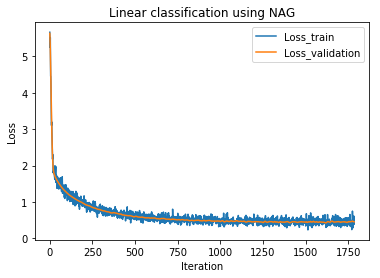

In [12]:
#NAG
lr = 0.02
epoch = 7
gamma = 0.8
lambdal = 0.01
batch_size = 128 # mini-batch gradient descent
runs = math.ceil(X_train.shape[0] / float(batch_size))
iteration = epoch * runs
#get different kinds of initial data（W_zeros,W_random or W_normal）
W = W_normal
Loss_train = np.zeros(iteration)
Loss_validation = np.zeros(iteration)
Accuracy = np.zeros(iteration)
v_t = np.zeros(N)
for j in range(0,epoch):
    #shuffles the array
    X_random,y_random = shuffle_array(X_train)
    for l in range(0,runs):
        #get the training instance and label in current batch
        X_batch,y_batch = get_Batch(runs,X_random,y_random,batch_size,X_train.shape[0])
        W_0 = W.copy()
        W_0[N-1]= 0
        #approximate W in the next time step
        W_t = W_0 - v_t * gamma
        #the training loss
        Loss_train[j*runs+l] = cal_Loss(X_batch,W,y_batch,lambdal,W_0)
        #the gradient of the loss function
        G = cal_G(X_batch,W_t,y_batch,lambdal,W_0)
        #the validation loss
        Loss_validation[j*runs+l] = cal_Loss(X_validation,W,y_validation,lambdal,W_0)
        #update the parameter W,b
        v_t = v_t * gamma + G * lr
        W = W - v_t
#draw the result
plt.plot(Loss_train,label="Loss_train")
plt.plot(Loss_validation,label="Loss_validation")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Linear classification using NAG")
plt.show()

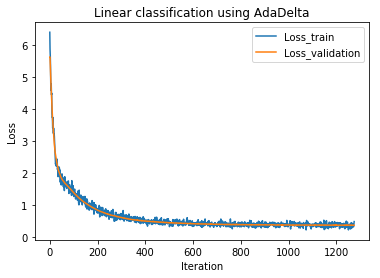

In [18]:
plt.close()
#AdaDelta
lr = 0.05
epoch = 5
lambdal = 0.01
gamma = 0.9
epsilon = np.e**(-8)
batch_size = 128 # mini-batch gradient descent
runs = math.ceil(X_train.shape[0] / float(batch_size))
iteration = epoch * runs
#get different kinds of initial data（W_zeros,W_random or W_normal）
W = W_normal
Loss_train = np.zeros(iteration)
Loss_validation = np.zeros(iteration)
Accuracy = np.zeros(iteration)
#the sum of the square of the gradient
G_2 = 0
W_2 = 0
RMS_g = 0
RMS_W = 0
W_delta = np.zeros(N)
for j in range(0,epoch):
    #shuffles the array
    X_random,y_random = shuffle_array(X_train)
    for l in range(0,runs):
        #get the training instance and label in current batch
        X_batch,y_batch = get_Batch(runs,X_random,y_random,batch_size,X_train.shape[0])
        W_0 = W.copy()
        W_0[N-1]= 0
        #the training loss
        Loss_train[j*runs+l] = cal_Loss(X_batch,W,y_batch,lambdal,W_0)
        #the gradient of the loss function
        G = cal_G(X_batch,W,y_batch,lambdal,W_0)
        #the validation loss
        Loss_validation[j*runs+l] = cal_Loss(X_validation,W,y_validation,lambdal,W_0)
        #update the parameter W,b
        G_2 = G_2 * gamma + np.dot(G,G.T) * (1-gamma)
        RMS_g = math.sqrt(G_2 + epsilon)
        W = W - G *(RMS_W / RMS_g)
        W_delta = G *(- lr / RMS_g)
        W_2 = W_2 * gamma + np.dot(W_delta,W_delta.T) * (1-gamma)
        RMS_W = math.sqrt(W_2 + epsilon)
#draw the result
plt.plot(Loss_train,label="Loss_train")
plt.plot(Loss_validation,label="Loss_validation")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Linear classification using AdaDelta")
plt.show()        

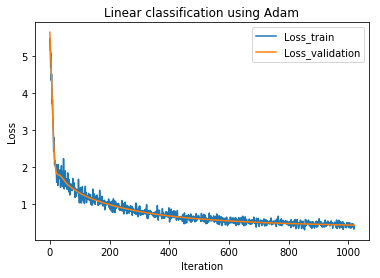

In [37]:
plt.close()
#Adam
lr = 0.07
epoch = 4
lambdal = 0.01
beta1 = 0.9
beta2 =0.999
epsilon = np.e**(-8)
batch_size = 128 # mini-batch gradient descent
runs = math.ceil(X_train.shape[0] / float(batch_size))
iteration = epoch * runs
#get different kinds of initial data（W_zeros,W_random or W_normal）
W = W_normal
Loss_train = np.zeros(iteration)
Loss_validation = np.zeros(iteration)
Accuracy = np.zeros(iteration)
#the estimates of the first and second moments
m_t = np.zeros(N)
n_t = 0
for j in range(0,epoch):
    #shuffles the array
    X_random,y_random = shuffle_array(X_train)
    for l in range(0,runs):
        #get the training instance and label in current batch
        X_batch,y_batch = get_Batch(runs,X_random,y_random,batch_size,X_train.shape[0])
        W_0 = W.copy()
        W_0[N-1]= 0
        #the training loss
        Loss_train[j*runs+l] = cal_Loss(X_batch,W,y_batch,lambdal,W_0)
        #the gradient of the loss function
        G = cal_G(X_batch,W,y_batch,lambdal,W_0)
        #the validation loss
        Loss_validation[j*runs+l] = cal_Loss(X_validation,W,y_validation,lambdal,W_0)
        #update the parameter W,b
        m_t = m_t * beta1 + G * (1-beta1)
        n_t = n_t * beta2 + np.dot(G,G.T) * (1-beta2)
        hat_m = m_t * (1/(1-beta1))
        hat_n = n_t * (1/(1-beta2))
        W = W - hat_m * (lr/(math.sqrt(hat_n)+epsilon))
#draw the result
plt.plot(Loss_train,label="Loss_train")
plt.plot(Loss_validation,label="Loss_validation")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Linear classification using Adam")
plt.show()          

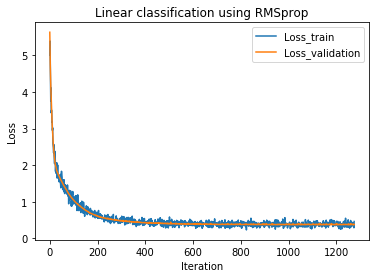

In [34]:
#RMSprop
plt.close()
lr = 0.08
epoch = 5
lambdal = 0.01
epsilon = np.e**(-8)
batch_size = 128 # mini-batch gradient descent
runs = math.ceil(X_train.shape[0] / float(batch_size))
iteration = epoch * runs
#get different kinds of initial data（W_zeros,W_random or W_normal）
W = W_normal
Loss_train = np.zeros(iteration)
Loss_validation = np.zeros(iteration)
Accuracy = np.zeros(iteration)
#the sum of the square of the gradient
G_2 = 0
for j in range(0,epoch):
    #shuffles the array
    X_random,y_random = shuffle_array(X_train)
    for l in range(0,runs):
        #get the training instance and label in current batch
        X_batch,y_batch = get_Batch(runs,X_random,y_random,batch_size,X_train.shape[0])
        W_0 = W.copy()
        W_0[N-1]= 0
        #the training loss
        Loss_train[j*runs+l] = cal_Loss(X_batch,W,y_batch,lambdal,W_0)
        #the gradient of the loss function
        G = cal_G(X_batch,W,y_batch,lambdal,W_0)
        #the validation loss
        Loss_validation[j*runs+l] = cal_Loss(X_validation,W,y_validation,lambdal,W_0)
        #update the parameter W,b
        G_2 = G_2 * 0.9 + np.dot(G,G.T) * 0.1
        W = W - G *(lr / math.sqrt(G_2 + epsilon))
#draw the result
plt.plot(Loss_train,label="Loss_train")
plt.plot(Loss_validation,label="Loss_validation")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Linear classification using RMSprop")
plt.show() 